In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
from scipy.interpolate import CubicSpline
from CozyMatrix import CozyMatrix

In [2]:
# Get the list of all files and directories
path = "C:/Users/dioge/Code/GitHub/2023-FRIB-TA-Summer-School/model-mixing/RBMSecar/Emulator/Results"
dir_list = os.listdir(path)
scales = [ float(name) for name in dir_list ]

In [3]:
big_matrix = []
for i in range(len(dir_list)):
    M1 = CozyMatrix(path+"/"+dir_list[i])
    big_row = []
    for mat in M1.matrices:
        for row in mat:
            big_row.append(row)
    big_matrix.append(big_row)
big_matrix = np.array(big_matrix)

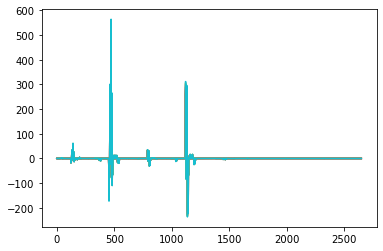

In [4]:
for i in range(10):
    plt.plot(big_matrix[i])
plt.show()

In [22]:
class Emulator:
    def __init__(self,axis,matrix,cutoff):
        self.axis   = axis
        self.matrix = matrix
        self.cutoff = cutoff
        self.height,self.width = self.matrix.shape
        self.build()
    
    def normalize(self):
        ''' Normalize the data '''
        self.means = [ np.average(self.matrix[:,i]) for i in range(self.width) ]
        self.sdevs = [ np.std(self.matrix[:,i])     for i in range(self.width) ]
        self.renor = [ [
                                ( self.matrix[i][j]-self.means[j] )/self.sdevs[j] 
                            if self.sdevs[j] != 0 else 0 
                        for j in range(self.width) ] 
                      for i in range(self.height) ]
        self.renor = np.array(self.renor)
    
    def build(self):
        self.normalize()
        self.u,self.s,self.v = np.linalg.svd(self.renor)
        self.splines = [ sp.interpolate.CubicSpline(self.axis,self.u[:,i]) for i in range(self.cutoff) ]
    
    def __call__(self,value):
        rval = np.zeros(self.width)
        for i in range(self.cutoff):
            rval += self.splines[i](value)*self.s[i]*self.v[i]
        rval = np.multiply(rval,self.sdevs) + self.means
        return rval

MagnetEmulator = Emulator(scales,big_matrix,15)

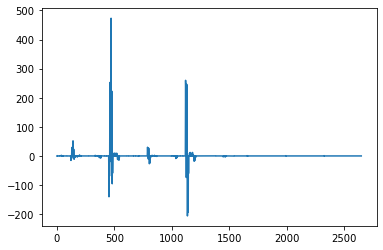

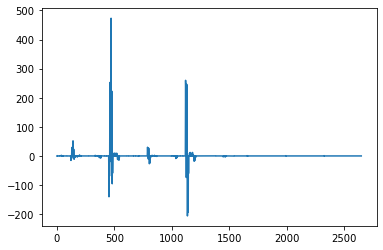

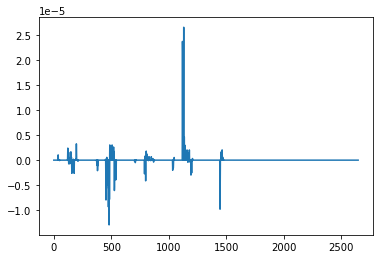

In [23]:
plt.plot(MagnetEmulator(0.5))
plt.show()
plt.plot(big_matrix[0])
plt.show()
plt.plot(MagnetEmulator(0.5)-big_matrix[0])

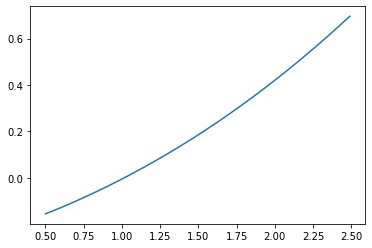

In [24]:
x = [ 0.5 + (i/100) for i in range(200) ]
y = [ MagnetEmulator.splines[0](xs) for xs in x ]
plt.plot(x,y)

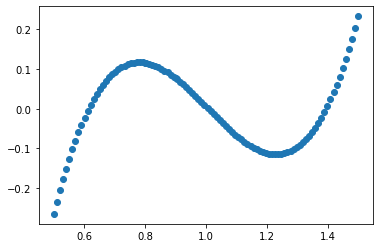

In [8]:
plt.scatter(MagnetEmulator.axis,MagnetEmulator.u[:,2])